In [2]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import io
import re
import zipfile
import json
from keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

# import fiftyone as fo
# import fiftyone.zoo as foz

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

PROJECT_ID = ""

if not os.getenv("IS_TESTING"):
    # Get your Google Cloud project ID from gcloud
    shell_output=!gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "bigbucket"  # @param {type:"string"}
from datetime import datetime
from google.colab import auth
auth.authenticate_user()
!echo "deb http://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!sudo apt-get -y -q update
!sudo apt-get -y -q install gcsfuse
!mkdir -p mush
bucket_name='medium_mush'
!gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 {bucket_name} mush

Project ID:  
deb http://packages.cloud.google.com/apt gcsfuse-bionic main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0   103k      0 --:--:-- --:--:-- --:--:--  103k
OK
Get:1 http://packages.cloud.google.com/apt gcsfuse-bionic InRelease [5,391 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad

In [4]:
def read_json(json_path):
    """ args = takes the Json files 
        returns = create the five dataframes for the five tables in the annotations json file
    """
    # # Opening JSON file
    f = open(json_path, )

    # returns JSON object as
    # a dictionary
    
    data = json.load(f)

    # Create different lists from the data dictionary

    annotations = pd.DataFrame(data["annotations"])
    category = pd.DataFrame(data["categories"])
    info = pd.DataFrame.from_dict(data["info"], orient='index')
    images = pd.DataFrame(data['images'])
    licenses = pd.DataFrame(data['licenses'])
    # Closing file
    f.close()
    return annotations, category, info, images, licenses

In [5]:
#!cp /content/drive/MyDrive/git/final/annotation.py /content/
json_train_path = '/content/mush/fungi/train.json'
json_val_path = '/content/mush/fungi/val.json'
tr_annotations, tr_category, tr_info, tr_images, tr_licenses = read_json(json_train_path)
val_annotations, val_category, val_info, val_images, val_licenses = read_json(json_val_path)

In [11]:
def create_merged_df(images, category, annotations):
    """args = takes the three important df's and returns a single df"""
    
    data_df = images.copy()

    data_df['category_id'] = annotations[annotations['image_id'] == data_df['id']]['category_id']
    category.set_index('id')
    data_df = pd.merge(left=data_df, right=category, how='left', left_on='category_id', right_on='id')
    data_df.drop(columns='id_y', inplace=True)

    data_df['image_name'] = data_df['file_name'].str.split('/').str[2]
    data_df['subdir'] = data_df['file_name'].str.split('/',1).str[1]
    return data_df

In [16]:
tr_data = create_merged_df(tr_images, tr_category, tr_annotations)
val_data = create_merged_df(val_images, val_category, val_annotations)

In [17]:
tr_data


,id_x,file_name,width,license,rights_holder,height,category_id,name,supercategory,image_name,subdir
0,21942,images/16390_Leucoagaricus_leucothites/OBL2010...,1300,1,Ole B. Lyshede,732,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC27332400.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC2733...
1,21943,images/16390_Leucoagaricus_leucothites/OBL2010...,1400,1,Ole B. Lyshede,788,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC74504431.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC7450...
2,21944,images/16390_Leucoagaricus_leucothites/OBL2010...,1400,1,Ole B. Lyshede,788,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC48004850.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC4800...
3,22210,images/16390_Leucoagaricus_leucothites/FDE2010...,567,1,Frank Desting,425,650,Leucoagaricus leucothites,Leucoagaricus,FDE2010PIC69596001.JPG,16390_Leucoagaricus_leucothites/FDE2010PIC6959...
4,24812,images/16390_Leucoagaricus_leucothites/FDE2010...,770,1,Frank Desting,577,650,Leucoagaricus leucothites,Leucoagaricus,FDE2010PIC10410554.JPG,16390_Leucoagaricus_leucothites/FDE2010PIC1041...
...,...,...,...,...,...,...,...,...,...,...,...
85573,38136,images/16382_Leucoagaricus_leucothites var. ca...,640,1,Peter Lausted,480,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,PEL2011PIC81452553.JPG,16382_Leucoagaricus_leucothites var. carneifol...
85574,76215,images/16382_Leucoagaricus_leucothites var. ca...,800,1,Westy Esbensen,532,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,WE2013PIC59907079.JPG,16382_Leucoagaricus_leucothites var. carneifol...
85575,76216,images/16382_Leucoagaricus_leucothites var. ca...,800,1,Westy Esbensen,595,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,WE2013PIC82590980.JPG,16382_Leucoagaricus_leucothites var. carneifol...
85576,107697,images/16382_Leucoagaricus_leucothites var. ca...,600,1,Kimmie Møenbo Jensen,800,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,KMO2016-9181394_rkuEVUwge.JPG,16382_Leucoagaricus_leucothites var. carneifol...


In [18]:
tr_data.dtypes

id_x              int64
file_name        object
width             int64
license           int64
rights_holder    object
height            int64
category_id       int64
name             object
supercategory    object
image_name       object
subdir           object
dtype: object

In [21]:
print(len(tr_data['category_id'].unique()), len(val_data['category_id'].unique()))

1394 1394


In [22]:
tr_data['category_id'].value_counts()

852     439
854     416
1103    411
86      403
732     372
       ... 
129       3
842       3
146       3
942       3
238       3
Name: category_id, Length: 1394, dtype: int64

In [24]:
tr_data['freq'] = tr_data.groupby('category_id')['category_id'].transform('count')

In [25]:
tr_data

,id_x,file_name,width,license,rights_holder,height,category_id,name,supercategory,image_name,subdir,freq
0,21942,images/16390_Leucoagaricus_leucothites/OBL2010...,1300,1,Ole B. Lyshede,732,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC27332400.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC2733...,81
1,21943,images/16390_Leucoagaricus_leucothites/OBL2010...,1400,1,Ole B. Lyshede,788,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC74504431.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC7450...,81
2,21944,images/16390_Leucoagaricus_leucothites/OBL2010...,1400,1,Ole B. Lyshede,788,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC48004850.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC4800...,81
3,22210,images/16390_Leucoagaricus_leucothites/FDE2010...,567,1,Frank Desting,425,650,Leucoagaricus leucothites,Leucoagaricus,FDE2010PIC69596001.JPG,16390_Leucoagaricus_leucothites/FDE2010PIC6959...,81
4,24812,images/16390_Leucoagaricus_leucothites/FDE2010...,770,1,Frank Desting,577,650,Leucoagaricus leucothites,Leucoagaricus,FDE2010PIC10410554.JPG,16390_Leucoagaricus_leucothites/FDE2010PIC1041...,81
...,...,...,...,...,...,...,...,...,...,...,...,...
85573,38136,images/16382_Leucoagaricus_leucothites var. ca...,640,1,Peter Lausted,480,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,PEL2011PIC81452553.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8
85574,76215,images/16382_Leucoagaricus_leucothites var. ca...,800,1,Westy Esbensen,532,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,WE2013PIC59907079.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8
85575,76216,images/16382_Leucoagaricus_leucothites var. ca...,800,1,Westy Esbensen,595,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,WE2013PIC82590980.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8
85576,107697,images/16382_Leucoagaricus_leucothites var. ca...,600,1,Kimmie Møenbo Jensen,800,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,KMO2016-9181394_rkuEVUwge.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8


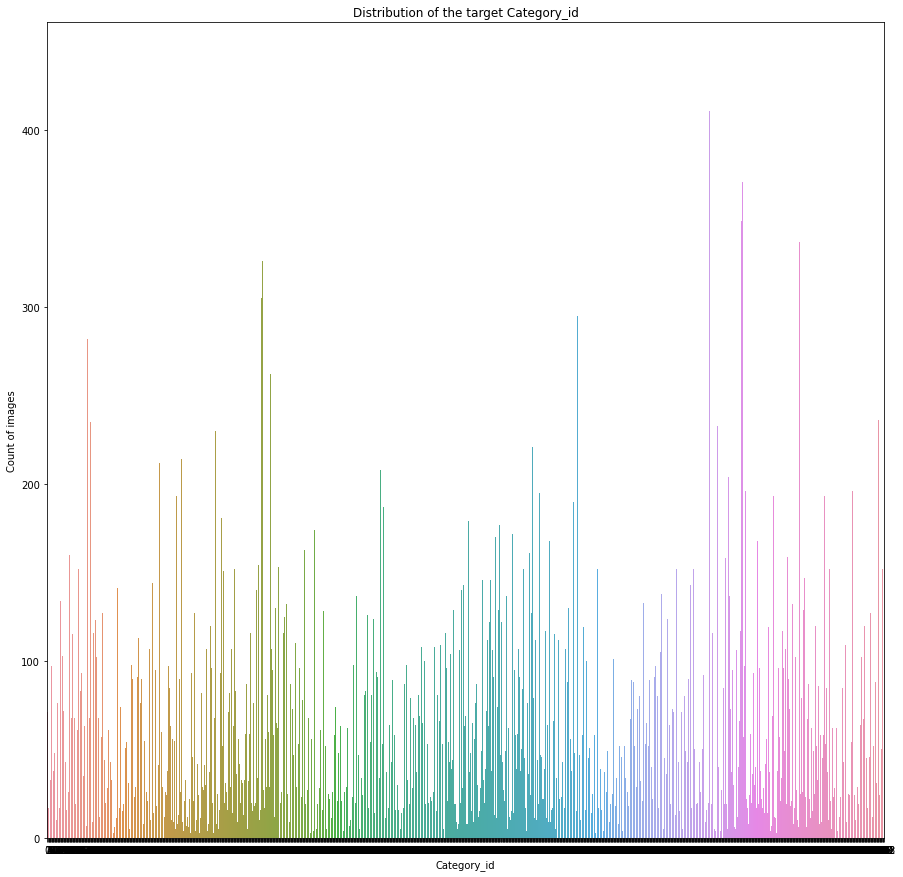

In [26]:
fig_dims = (15,15)

fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.barplot(x = 'category_id', y = 'freq',data = tr_data)
plt.title('Distribution of the target Category_id')
plt.xlabel('Category_id')
plt.ylabel('Count of images')
plt.show()

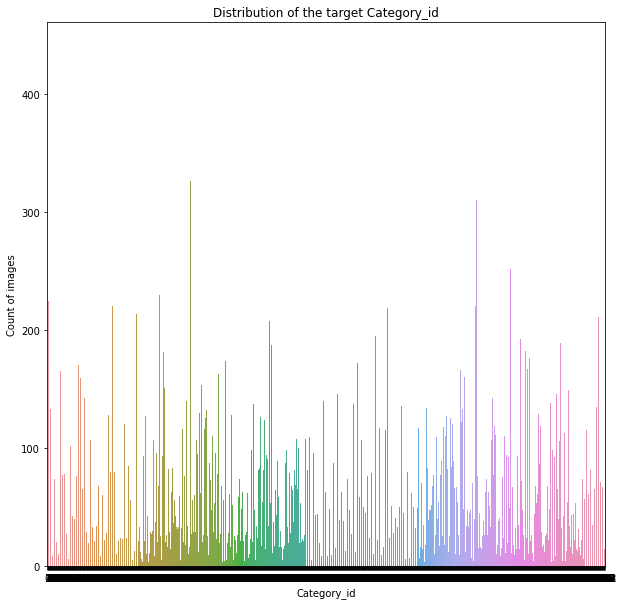

In [27]:
fig_dims = (10,10)

fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.countplot(x = 'category_id', data = tr_data)
plt.title('Distribution of the target Category_id')
plt.xlabel('Category_id')
plt.ylabel('Count of images')
plt.show()

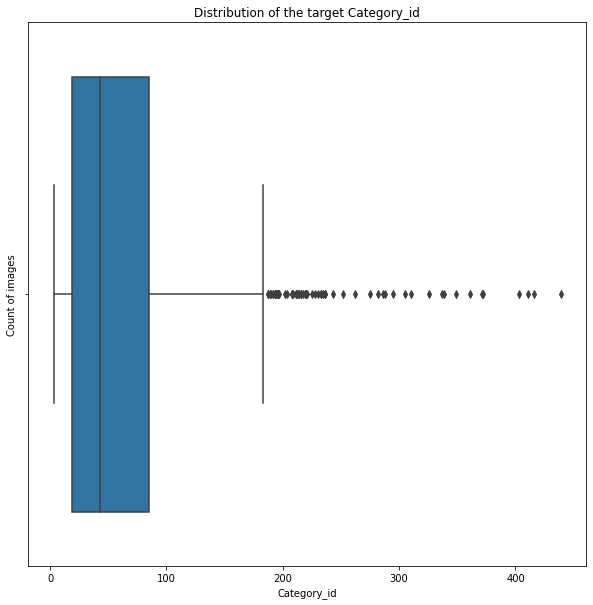

In [28]:
fig_dims = (10,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x=tr_data['category_id'].value_counts())
plt.title('Distribution of the target Category_id')
plt.xlabel('Category_id')
plt.ylabel('Count of images')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


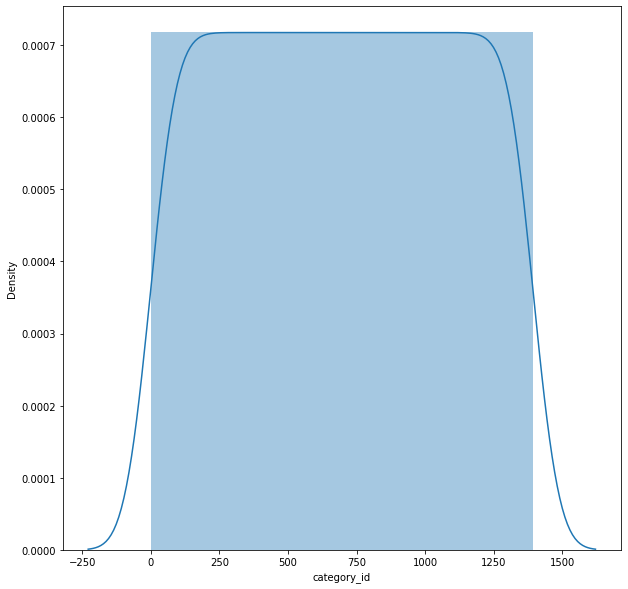

In [29]:
fig_dims = (10,10)

fig, ax = plt.subplots(figsize=fig_dims)

sns.distplot(val_data['category_id'])
plt.show()

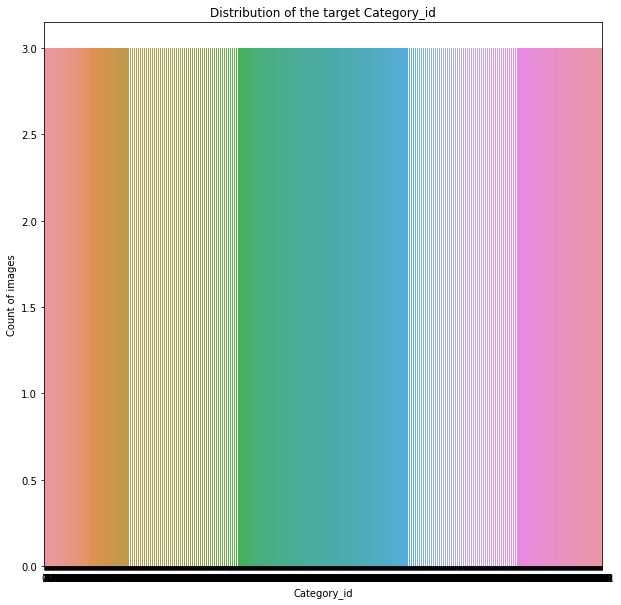

In [30]:
fig_dims = (10,10)

fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.countplot(x = 'category_id', data = val_data)
plt.title('Distribution of the target Category_id')
plt.xlabel('Category_id')
plt.ylabel('Count of images')
plt.show()

In [33]:
tr_data.to_csv('/content/mush/fungi/training_annot.csv', index=False)
val_data.to_csv('/content/mush/fungi/val_annot.csv', index=False)

In [32]:
tr_data

,id_x,file_name,width,license,rights_holder,height,category_id,name,supercategory,image_name,subdir,freq
0,21942,images/16390_Leucoagaricus_leucothites/OBL2010...,1300,1,Ole B. Lyshede,732,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC27332400.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC2733...,81
1,21943,images/16390_Leucoagaricus_leucothites/OBL2010...,1400,1,Ole B. Lyshede,788,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC74504431.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC7450...,81
2,21944,images/16390_Leucoagaricus_leucothites/OBL2010...,1400,1,Ole B. Lyshede,788,650,Leucoagaricus leucothites,Leucoagaricus,OBL2010PIC48004850.JPG,16390_Leucoagaricus_leucothites/OBL2010PIC4800...,81
3,22210,images/16390_Leucoagaricus_leucothites/FDE2010...,567,1,Frank Desting,425,650,Leucoagaricus leucothites,Leucoagaricus,FDE2010PIC69596001.JPG,16390_Leucoagaricus_leucothites/FDE2010PIC6959...,81
4,24812,images/16390_Leucoagaricus_leucothites/FDE2010...,770,1,Frank Desting,577,650,Leucoagaricus leucothites,Leucoagaricus,FDE2010PIC10410554.JPG,16390_Leucoagaricus_leucothites/FDE2010PIC1041...,81
...,...,...,...,...,...,...,...,...,...,...,...,...
85573,38136,images/16382_Leucoagaricus_leucothites var. ca...,640,1,Peter Lausted,480,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,PEL2011PIC81452553.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8
85574,76215,images/16382_Leucoagaricus_leucothites var. ca...,800,1,Westy Esbensen,532,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,WE2013PIC59907079.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8
85575,76216,images/16382_Leucoagaricus_leucothites var. ca...,800,1,Westy Esbensen,595,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,WE2013PIC82590980.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8
85576,107697,images/16382_Leucoagaricus_leucothites var. ca...,600,1,Kimmie Møenbo Jensen,800,649,Leucoagaricus leucothites var. carneifolius,Leucoagaricus,KMO2016-9181394_rkuEVUwge.JPG,16382_Leucoagaricus_leucothites var. carneifol...,8


In [36]:
X = np.array(tr_data['file_name'])
y = np.array(tr_data['category_id'])